# Import all libs

In [20]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
import numpy as np
import h5py

FMRI_DIR = 'C:/Users/007303173/Documents/Independent_Study_Project/nsd_data/GLM-fmri-data/subj01'
TRIAL_PER_SESS = 750
POSITIVE_DIRECTORY =  'C:/Users/007303173/Documents/Independent_Study_Project/nsd_data/standardized-betas/subj01/isCorrect/'
NEGATIVE_DIRECTORY =  'C:/Users/007303173/Documents/Independent_Study_Project/nsd_data/standardized-betas/subj01/isNotCorrect/'


In [2]:
def read_hdf5_file(file_path):
  with h5py.File(file_path, 'r') as f:
    betas = f['betas'][:]
  return betas

  # returns a list of all files in the directory
def getDirFiles(file_dir):
     files = [f for f in os.listdir(file_dir) if 
              os.path.isfile(os.path.join(file_dir, f))]
     files.sort()                          
     return files

In [3]:
positive_paths = [os.path.join(POSITIVE_DIRECTORY, path) for path in getDirFiles(POSITIVE_DIRECTORY)]
negative_paths = [os.path.join(NEGATIVE_DIRECTORY, path) for path in getDirFiles(NEGATIVE_DIRECTORY)]

In [4]:
def getSamples(path, num_samples = False):
    total_samples = []
    samples_size = 0
    for data_file in path:
        with h5py.File(data_file, "r") as f:
            betas = f['betas']
            samples_size += betas.shape[0]
            total_samples.append(betas[:])
            
            if num_samples != False and samples_size > num_samples:
                break
   
    return np.concatenate(total_samples)

In [5]:
negative_samples = getSamples(negative_paths)

In [7]:
positive_samples = getSamples(positive_paths, num_samples= len(negative_samples))

In [10]:
print(len(positive_samples))
print(len(negative_samples))

4491
4210


In [8]:


positive_labels = np.array([1 for _ in range(len(positive_samples))])
negative_labels = np.array([0 for _ in range(len(negative_samples))])
# Split data in the ratio 80-20 for training and validation.
split_pos = round(len(positive_labels) *.2)
split_neg = round(len(negative_labels) *.2)

x_train = np.concatenate((positive_samples[:split_pos], negative_samples[:split_neg]), axis=0)
y_train = np.concatenate((positive_labels[:split_pos], negative_labels[:split_neg]), axis=0)

x_val = np.concatenate((positive_samples[split_pos:], negative_samples[split_neg:]), axis=0)
y_val = np.concatenate((positive_samples[split_pos:], negative_samples[split_neg:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)



Number of samples in train and validation are 1740 and 6961.


In [15]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.double)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [16]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (83, 104, 81, 1)


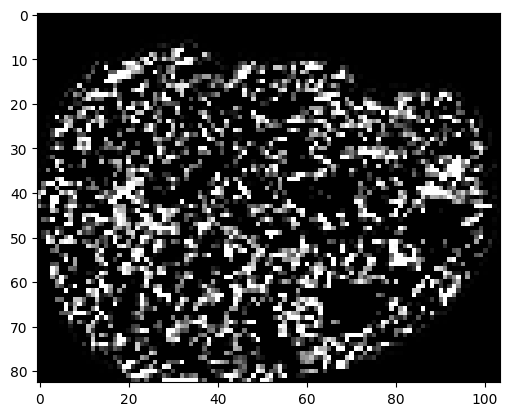

In [17]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

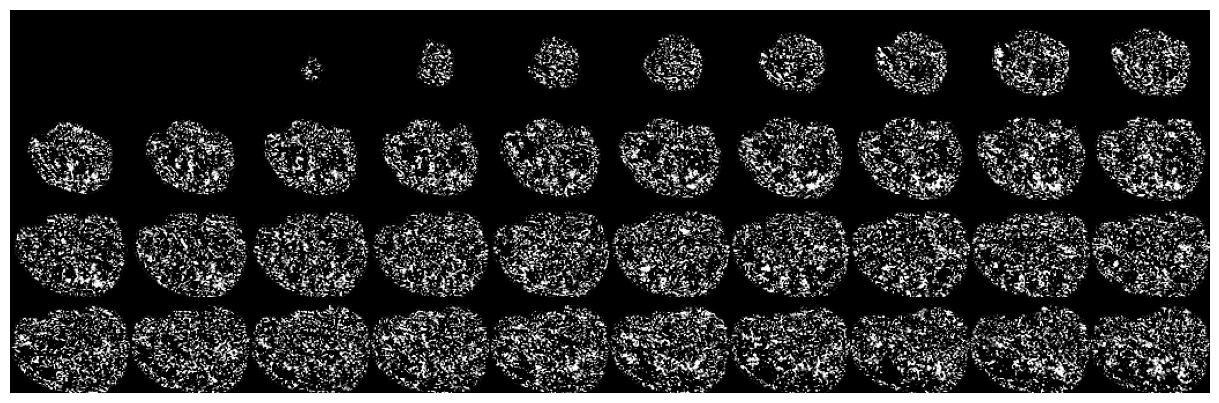

In [18]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 83, 104, image[:, :, :40])

In [21]:
def get_model(width=83, height=104, depth=81):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=83, height=102, depth=81)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 83, 102, 81, 1)]  0         
                                                                 
 conv3d (Conv3D)             (None, 81, 100, 79, 64)   1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 40, 50, 39, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 40, 50, 39, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 38, 48, 37, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 19, 24, 18, 64)   0     

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)